# Neural Network Regression for Depth Thermography Focusing on Per-Layer Prediction

In [196]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import random
%matplotlib inline

In [197]:
# model parameters
args = {'lr':0.01,
        'train epochs':5000,
        'noise':0.01,
        'train size':0.7,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler()
        }

# Data Preprocessing

In [198]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [199]:
# read in data
df = pd.read_excel('data_3nm.xlsx')

In [200]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [201]:
# function to add noise as a percentage 
def add_noise(data, percentage):
    std_dev = percentage * data.std().sum()/len(data)
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [202]:
# add noise
X_noisy = add_noise(X, args['noise'])

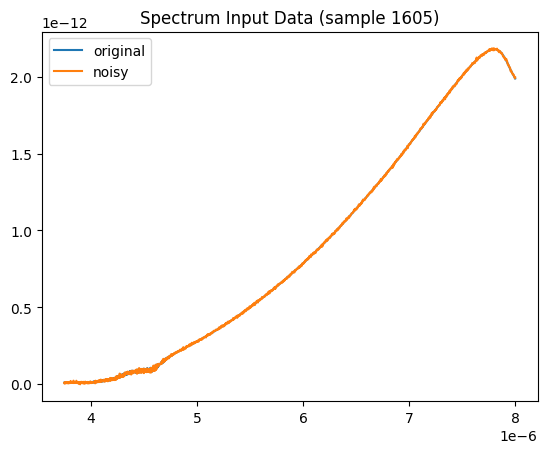

In [203]:
# plot original vs noisy data
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [204]:
# scale data
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [205]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'])

In [206]:
# seperates each column of the data for each temperature layer
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

# convert X data to tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

## Setup Models

In [207]:
# define network architecture
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedForward, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 15)
        self.lin_fin = nn.Linear(15, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = self.lin_fin(x)
        return x

## Train Models

In [208]:
# define loss function
criterion = args['train criterion']

In [209]:
# iterate through each temperature layer
for layer in layers:

    # get target data from dictionary
    target = layer['y_train']

    # instantiate model
    model = FeedForward(X_train_tensor.size()[1], target.size()[1])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    # define optimizer for model
    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])

    # training loop
    for epoch in range(args['train epochs']):
        # forward pass
        outputs = model(X_train_tensor)

        # get loss
        loss = criterion(outputs, target)

        # update and backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    # store model and losses
    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1
epoch: 500, loss = 2.965764284133911
epoch: 1000, loss = 2.6929595470428467
epoch: 1500, loss = 2.679366111755371
epoch: 2000, loss = 2.679366111755371
epoch: 2500, loss = 2.679366111755371
epoch: 3000, loss = 2.679366111755371
epoch: 3500, loss = 2.679366111755371
epoch: 4000, loss = 2.679366111755371
epoch: 4500, loss = 2.679366111755371
epoch: 5000, loss = 2.679366111755371
best loss: 2.6793549060821533 in epoch 1369

layer 2
epoch: 500, loss = 6.163773536682129
epoch: 1000, loss = 5.6122145652771
epoch: 1500, loss = 5.499565124511719
epoch: 2000, loss = 5.495707035064697
epoch: 2500, loss = 5.495445728302002
epoch: 3000, loss = 5.490780353546143
epoch: 3500, loss = 5.490457057952881
epoch: 4000, loss = 5.490261554718018
epoch: 4500, loss = 5.489794731140137
epoch: 5000, loss = 5.48951530456543
best loss: 5.489481449127197 in epoch 4998

layer 3
epoch: 500, loss = 2.6343653202056885
epoch: 1000, loss = 2.443866014480591
epoch: 1500, loss = 2.4067142009735107
epoch: 2000, los

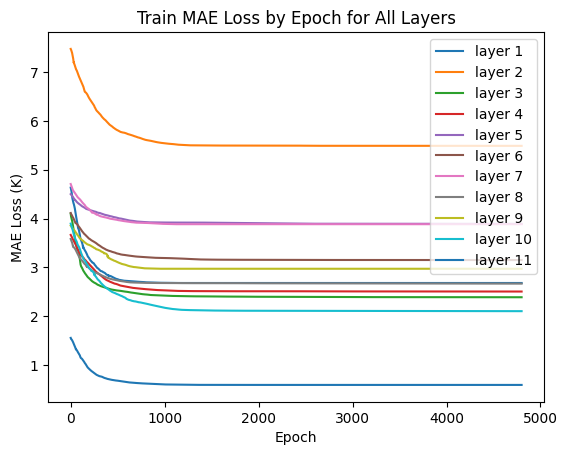

In [210]:
# plot losses over epochs
for layer in layers:
    plt.plot(layer['train losses'][200:], label=layer['col'])

    
plt.title(f"Train MAE Loss by Epoch for All Layers")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

## Test Models

In [211]:
test_losses = []
test_criterion = args['test criterion']

# iterate through temperature layers and test losses
for layer in layers:
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(X_test_tensor)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

        layer['test pred'] = pred

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

average_loss = sum(test_losses)/len(test_losses)
print(f"Average: {average_loss}")

layer 1 loss: 3.4438672065734863
layer 2 loss: 7.691771030426025
layer 3 loss: 3.3983964920043945
layer 4 loss: 3.657069444656372
layer 5 loss: 4.956811428070068
layer 6 loss: 4.119547367095947
layer 7 loss: 5.072598457336426
layer 8 loss: 4.2169904708862305
layer 9 loss: 3.6474761962890625
layer 10 loss: 2.8536360263824463
layer 11 loss: 0.8180594444274902
Average: 3.9887475967407227


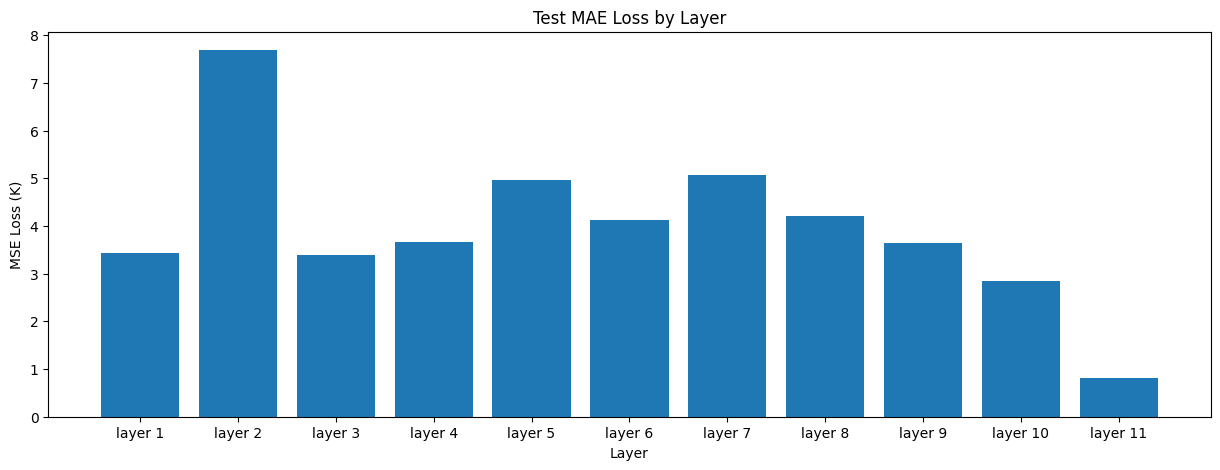

In [212]:
# plot losses
plt.figure(figsize=(15, 5))
plt.bar(y.columns, test_losses)

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [213]:
# function to plot comparison between actual and predicted values
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [214]:
# get actual and predicted values for plots
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

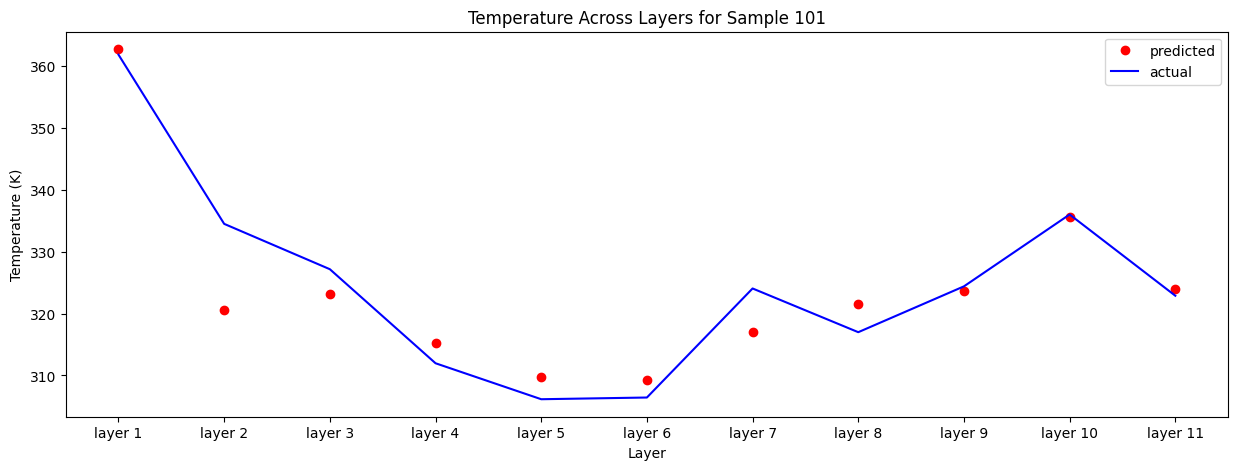

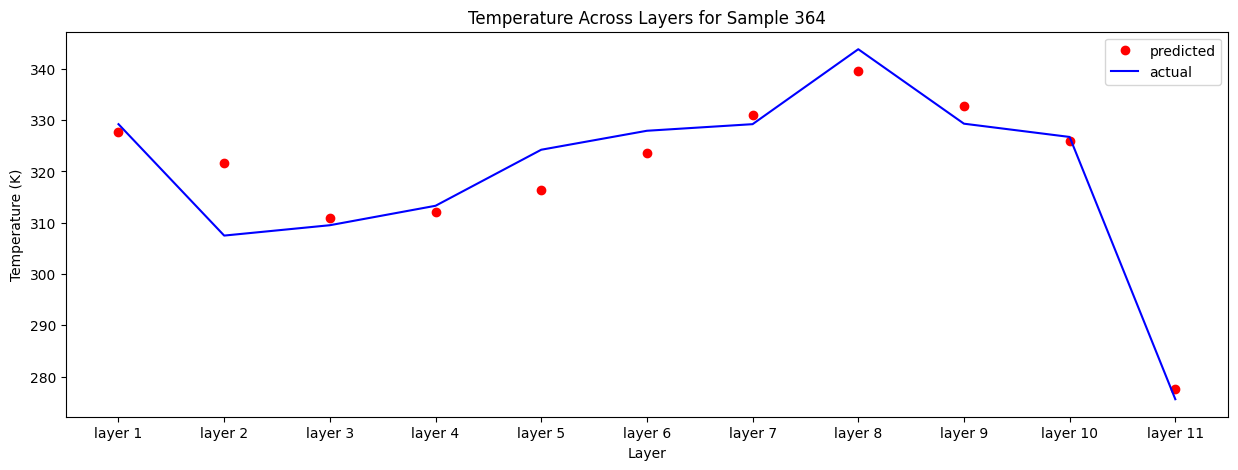

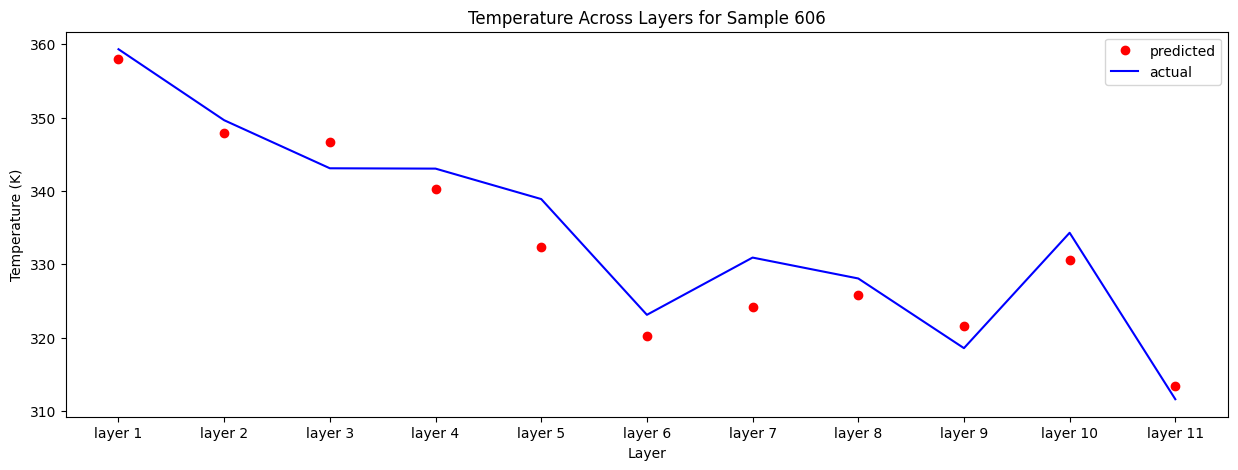

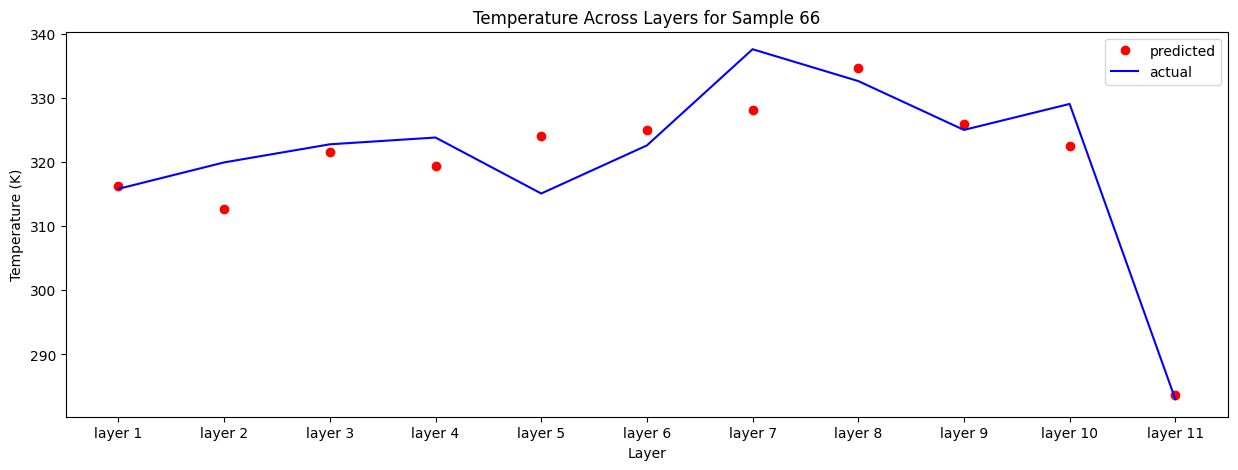

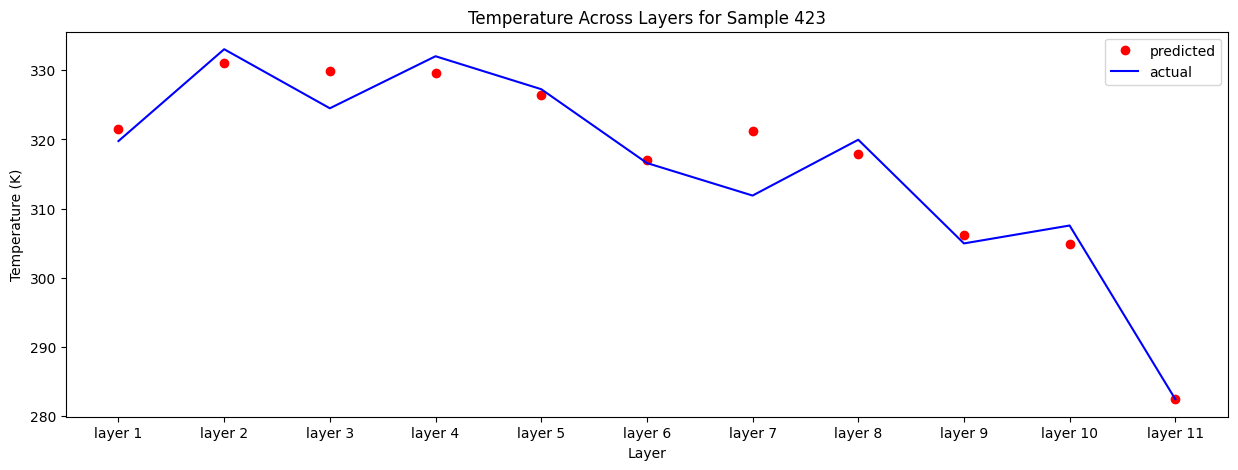

In [215]:
# pick 5 random entries and plot the comparison between predicted and acutal values
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual, i)

In [216]:
with open('one_layer_results.txt', 'a') as file:
    file.write(f'{average_loss}, ')